# An integrated diagnostic analysis of plasma waves

## Setup
Identify time ranges into which to separate the analysis. Locate crash times and define widows just before and just after them. Various plots shown to indicate suitability of ranges and windows.


Import necessary packages

In [1]:
from lib.imports_BES import *
#from lib.functions_BES import *
from lib.analysis_functions_BES import *
from lib.analysis_functions_Mirnov import *
from lib.plotting_functions_BES import *
from lib.analysis_functions_general import *

Some variables for simplification

In [2]:
# Specify path to where data is stored
bes_data_path = "BES_code_local/Data/"
mirnov_data_path = "Mirnov_code_local/Data/"

# For labelling outputs
shot = 29378
shotlabel = "\#" + str(shot)

Load BES data from various NETCDF files

In [3]:
# Main BES data. Array for times and shape (32,time) array for fluctuation
fluct_data_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_LH_fluct_data.nc")
bes_time = np.asarray(fluct_data_from_file.coords['time'])
fluct_data = np.asarray(fluct_data_from_file)

# Sampling rate calculation
f_samp_BES = 1/(np.mean(np.diff(bes_time)))

# (R, z) locations for the BES channels. Shape: (32,2)
apdpos = np.asarray(xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_apdpos.nc"))

Load Mirnov coil data

In [4]:
# Get coil positions
coilpos = np.asarray(xr.open_dataarray(mirnov_data_path + "coil_positions.nc"))

# Main Mirnov data
mirnov_data_from_file = xr.open_dataarray(mirnov_data_path + "shot" + str(shot) + "_mirnov_data.nc")
mirnov_time = np.asarray(mirnov_data_from_file.coords['time'])
coil_nums = np.asarray(mirnov_data_from_file.coords['coil']) # Coil numbers e.g. 210 for coils in order of data
mirnov_data = np.asarray(mirnov_data_from_file) # Shape (11,650000)

# Sampling rate calculation
f_samp_mirnov = 1/(np.mean(np.diff(mirnov_time)))

# Useful coils appear to be [206, 207, 210, 212, 213, 214]
coil_nums = coil_nums[1:7]
mirnov_data = mirnov_data[1:7]
#for i in range(len(mirnov_data)):
#    mirnov_data[i] = mirnov_data[i]/np.std(mirnov_data[i])
coilpos = coilpos[1:7]

Load other useful data

In [5]:
# Dalpha data. Array for time and array for values
dalpha_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_dalpha.nc")
dalpha_time = np.asarray(dalpha_from_file.coords['time'])
dalpha_data = np.asarray(dalpha_from_file)

# Upper tangential Dalpha. Array for time and array for values
utda_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_upper_tan_dalpha.nc")
utda_time = np.asarray(utda_from_file.coords['time'])
utda_data = np.asarray(utda_from_file)

# Line-averaged density. Array for time and array for values
density_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_density.nc")
density_time = np.asarray(density_from_file.coords['time'])
density_data = np.asarray(density_from_file)

# Equilibria from EFIT. Two spacial arrays, a time array and 2D array of psi
equilib_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_equilibria.nc")
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file)

Plot $D_\alpha$ data to identify times of interest then input ranges to separate analysis into. Change these as needed

In [6]:
# Change regions' bounds as needed
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

# BES time is limited to ~0.65
for i in range(len(regions)):
    if regions[i][1] > bes_time[-1]:
        print("Region", i, "trimmed", str(regions[i]), "to", np.around([regions[i][0], bes_time[-1]],2))
        regions[i] = [regions[i][0], bes_time[-1]]

Region 2 trimmed [0.54, 0.68] to [0.54 0.65]


Plot regions so time ranges can be fine-tuned.

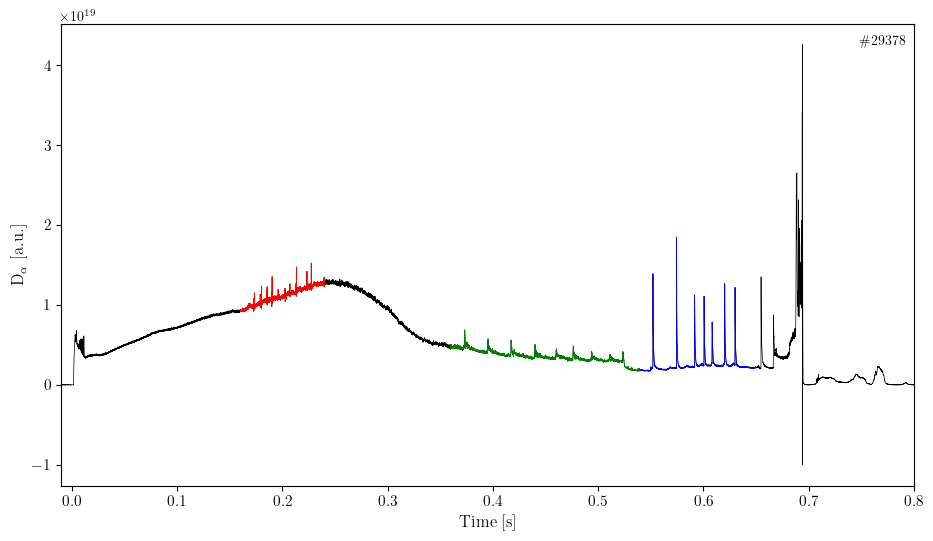

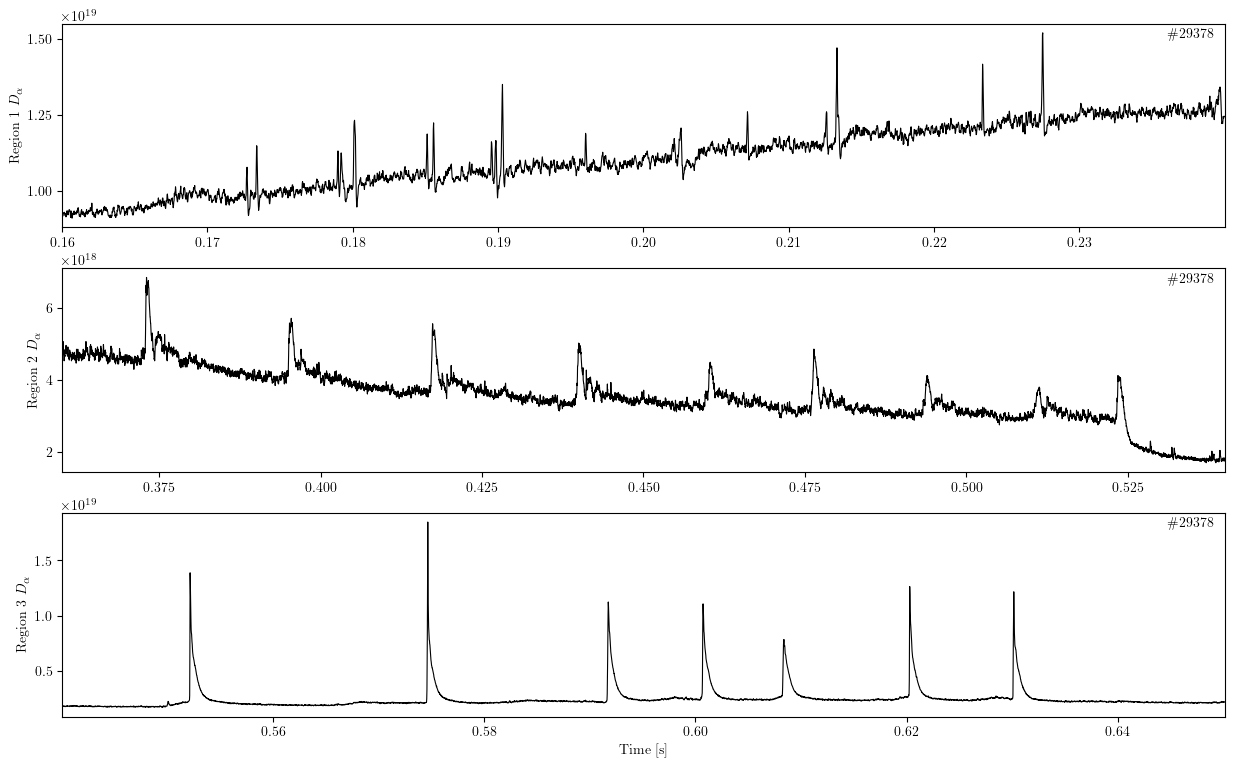

In [7]:
if True:
    colours = ["r", "g", "b", "c", "m", "y"] # Each region plotted in different colour
    
    # Big plot of Dalpha with regions differently colours
    fig1, ax1 = plt.subplots(1, 1, figsize=(11, 6))
    ax1.plot(dalpha_time, dalpha_data, 'k', linewidth=0.5)

    # Plots of each region separately
    fig2, ax2 = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

    for i in range(len(regions)):
        idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
        idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
        ax1.plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1], colours[i], linewidth=0.5)

        ax2[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
        ax2[i].tick_params(axis='x')
        ax2[i].tick_params(axis='y')
        ax2[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
        ax2[i].locator_params(axis='y', nbins=3)
        ax2[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
        ax2[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

    ax1.set_xlabel("Time [s]", fontsize=12)
    ax1.set_ylabel(r"D$_\alpha$ [a.u.]", fontsize=12)
    ax1.set_xlim([dalpha_time[0], 0.8])
    ax1.tick_params(axis='both', which='major', labelsize=11)
    ax1.text(.99, .975, shotlabel, ha='right', va='top', transform=ax1.transAxes)

    ax2[-1].set_xlabel("Time [s]")

    fig1.savefig("Full_Dalpha_plot.pdf", format="pdf", bbox_inches="tight")
    #fig2.savefig("Dalpha_region_plots.pdf", format="pdf", bbox_inches="tight")

    plt.show()
    plt.close()

Now use tangential $D_\alpha$ data to identify crash times. Set threshold for each region so that the blue line runs below most of the peaks while avoiding baseline noise.

In [8]:
thresholds = [0.04, 0.008, 0.02]
if False:
    figure, axes = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

    for i in range(len(regions)):
        idx1 = (np.abs(utda_time - regions[i][0])).argmin()
        idx2 = (np.abs(utda_time - regions[i][1])).argmin()

        axes[i].plot(utda_time[idx1:idx2], np.gradient(utda_data[idx1:idx2]), "k", linewidth=0.5)
        axes[i].hlines(thresholds[i], utda_time[idx1], utda_time[idx2], linewidth=0.5)
        axes[i].set_ylabel("Region " + str(i+1))
        axes[i].locator_params(axis="y", nbins=7)
        axes[i].text(.99, .975, shotlabel, ha='right', va='top', transform=axes[i].transAxes)
        axes[i].set_xlim([utda_time[idx1], utda_time[idx2]])

    axes[-1].set_xlabel("Time [s]")
    axes[0].set_title(r"Upper tangential $D_\alpha$ derivative")
    plt.subplots_adjust(hspace=0.5)

    plt.show()
    plt.close()

Using thresholds defined above, find windows around crashes

Change start/end shifts as needed

In [104]:
pre_crash_windows = {}
post_crash_windows = {}
crash_times = {}

crash_times[0] = get_crash_times(utda_time, utda_data, thresholds[0], regions[0])
pre_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=2e-3, end_shift=0.5e-3)
post_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=-0.5e-3, end_shift=-2e-3)

crash_times[1] = get_crash_times(utda_time, utda_data, thresholds[1], regions[1])
pre_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=-1e-3, end_shift=-5e-3)

crash_times[2] = get_crash_times(utda_time, utda_data, thresholds[2], regions[2])
pre_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=-1e-3, end_shift=-5e-3)

Make some plots to check that windows found are sensible, readjust above as needed

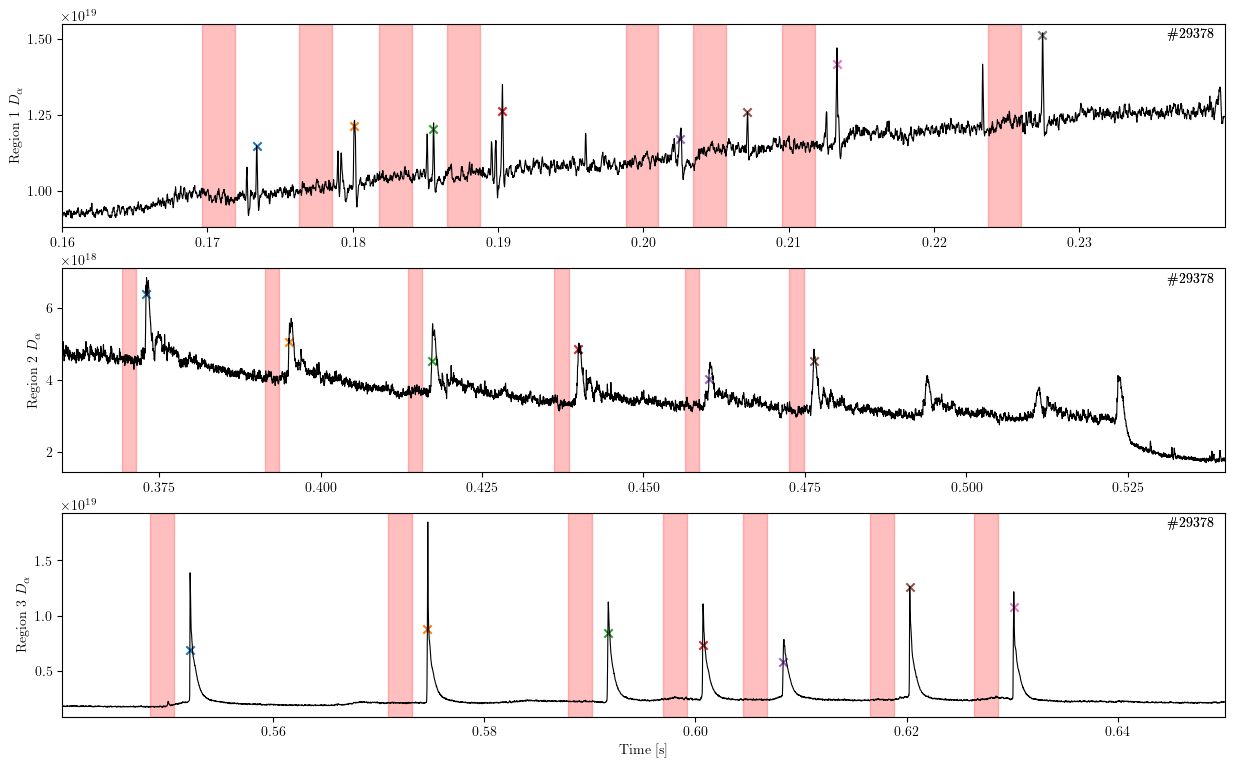

In [10]:
if True:
    # Plots of each region separately with found crashes marked
    fig, ax = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 3*len(regions)))

    for i in range(len(regions)):
        idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
        idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()

        ax[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
        ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)
        
        for peak in crash_times[i]:
            crash_amplitude = dalpha_data[(np.abs(dalpha_time - peak)).argmin()]
            ax[i].scatter(peak, crash_amplitude, marker="x")

        for pre_window in pre_crash_windows[i]:
            #ax[i].vlines(pre_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "g", linestyle="dashed", linewidth=0.5)
            #ax[i].vlines(pre_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "r", linestyle="dashed", linewidth=0.5)
            ax[i].axvspan(pre_window[0], pre_window[1], alpha=0.25, color='red')

        #for post_window in post_crash_windows[i]:
            #ax[i].vlines(post_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "m", linestyle="dotted", linewidth=0.5)
            #ax[i].vlines(post_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "c", linestyle="dotted", linewidth=0.5)
        #    ax[i].axvspan(post_window[0], post_window[1], alpha=0.25, color='cyan')

        ax[i].tick_params(axis='x')
        ax[i].tick_params(axis='y')
        ax[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
        ax[i].locator_params(axis='y', nbins=3)
        ax[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
        ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)

    ax[-1].set_xlabel("Time [s]")
    plt.show()
    plt.close()

Show windows on spectrograms. Only one column plotted as they aren't significantly different - crashes appear at pretty much the same time in all columns.

In [11]:
if False:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 5, regions[i], vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 5, regions[i], vlines=post_crash_windows[i], plot=True)

Once happy, calculate average distance of each column from separatrix over a given timeslice and/or read into a dataframe.

In [12]:
if False:
    # The calcs take some time, so best run once and save in file
    with open("dist_in_sol.csv", "w") as f:
        f.write("Region")
        for i in range(8):
            f.write(",Col " + str(i+1))
        f.write("\n")

        for region in range(len(regions)):
            f.write(str(region+1))
            for col in range(8):
                f.write("," + str(sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, regions[region], col)))
            f.write("\n")

dists_in_sol = pd.read_csv("BES_code_local/Data/dist_in_sol.csv", index_col=0)

# Analysis

By this point you should be happy with the regions and the pre- and post-crash windows.

Generate dispersion relations in crash-adjacent windows using BES data

In [ ]:
if True:
    for region in range(2,3):#range(len(regions)):
        for col in range(8):
            sol_dist = np.round(dists_in_sol.loc[region+1].at["Col " + str(col)],2)
            plot_title = "\#" + str(shot) + r" $\rho_{\rm SOL}=\,$" + str(sol_dist) + " m, pre-flashes in $t =\,$" + str(list(np.round(regions[region],2))) + " s"
            fn = "diss_plots/kf_pre_reg_" + str(region+1) + "_col_" + str(col+1)
            xlabel = "Wavenumber [m$^{-1}$]"
            f_arr, k_arr, kf_matrix = kf_spec_sum_windows(bes_time, fluct_data, apdpos, col, pre_crash_windows[region])
            plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=10.0e3, fmax=50.0e3, smooth_pts=5, conditional=False, save=False)

Plot frequency profiles from dispersion relations

In [ ]:
if True:
    for region in range(2,len(regions)):
        for col in range(8):
            fn = "Plots/f_pre_reg_" + str(region+1) + "_col_" + str(col+1)
            plot_title = "Col " + str(col+1) + " pre-crash in t=" + str(list(np.round(regions[region],2))) + r" s $f$ profile"
            f_arr, f_dat = plot_freq_profile(shot, bes_time, fluct_data, apdpos, col, pre_crash_windows[2], [50.0,75.0,100.0], ylims=None, fmin=30.0e3, fmax=35.0e3, plot=plot_title, save=False)

Plot wavenumber profiles from dispersion relations

In [ ]:
def plot_wavenum_profile2(shot, bes_time, fluct_data, apdpos, col, timeslices, f_range, plot=False, fit=None, save=False):
    f_arr, k_arr, kf_matrix = kf_spec_sum_windows(bes_time, fluct_data, apdpos, col, timeslices)
    f_start = (np.abs(f_arr-f_range[0])).argmin()
    f_end = (np.abs(f_arr-f_range[1])).argmin()
    profile = np.sum(kf_matrix[f_start:f_end,:],axis=0)
    
    start = 5
    end = len(k_arr)
    if fit != None:
        popt, pcov = curve_fit(fit, k_arr[start:end], profile[start:end])
        residuals = profile[start:end] - fit(k_arr[start:end], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[start:end] - np.mean(profile[start:end]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[start], k_arr[end-1], 100)
        fit_y = fit(fit_x, *popt)

    if plot != False:
        fig, ax = plt.subplots(1, 1, figsize=(7, 4))
        #ax.scatter(k_arr, np.log(np.abs(profile)**2), linewidth=0.5, marker="x")
        ax.scatter(k_arr, profile, linewidth=0.5, marker="x")
        if fit != None:
            #ax.plot(fit_x, np.log(np.abs(fit_y)**2), linewidth=0.5)
            ax.plot(fit_x, fit_y, linewidth=0.5)
            annot = r"$\mu=$" + str(np.round(popt[1],3)) + " $\mathrm{m^{-1}}$, $R^2=$" + str(np.round(r_squared,3))
            ax.legend(["Data", fit.__name__ + " fit"], loc="upper right")
            ax.text(0.01, 0.975, annot, ha='left', va='top', transform=ax.transAxes)
        
        ax.set_title(plot)
        ax.text(.99, 1.045, "\#" + str(shot), ha='right', va='top', transform=ax.transAxes)
        ax.set_xlabel(r"Wavenumber [$\mathrm{m^{-1}}$]")
        ax.set_ylabel(r"$S(k)$")
        ax.set_xlim([k_arr[0], k_arr[-1]])
        f_annot = str(list(np.round((np.asarray(f_range)*1e-3).astype(int),0))) + " kHz"
        ax.text(0.01, 0.915, r"$f\in$" + f_annot, ha='left', va='top', transform=ax.transAxes)

        if save != False:
            plt.savefig(save + ".png", format="png", bbox_inches="tight", dpi=300)
        else:
            plt.show()
        plt.close()
    if fit != None:
        return k_arr, profile, popt[1]
    else:
        return k_arr, profile

In [ ]:
if True:
    for region in range(2,3):#len(regions)):
        avgs = []
        for col in range(7):
            fn = "Plots/k_pre_reg_" + str(region+1) + "_col_" + str(col+1)
            plot_title = "Col " + str(col+1) + " pre-crash in t=" + str(list(np.round(regions[region],2))) + r" s $k$ profile"
            k_arr, profile, mu = plot_wavenum_profile2(shot, bes_time, fluct_data, apdpos, col, pre_crash_windows[region], [30.0e3, 35.0e3], fit=gaussian, plot=plot_title, save=False)
            avgs.append(mu)
        print("Mean:", np.mean(avgs), "stdev:", np.std(avgs))

Visualise what the crash-adjacent windows actually cover by looking at them over Mirnov spectrogram

In [ ]:
def mirnov_stft_diss(shot, mirnov_time, mirnov_data, timeslice, n=8, freq_lims=[0.0, 200.0], vlines=None, plot=True, save=False):
    # plot the BES fluctuation data spectrogram for one or more channels, L. Howlett adapted by A. Caplan
    idx1 = (np.abs(mirnov_time - timeslice[0])).argmin()
    idx2 = (np.abs(mirnov_time - timeslice[1])).argmin()
    
    freq, times, Sxx = sig.spectrogram(mirnov_data[:,idx1:idx2+1], fs=f_samp_mirnov, 
                                       nperseg=(2 ** n), scaling='spectrum')
    
    new_lim = len(freq)#int(14 * (2 ** (n - 7)))
    summed_Sxx = np.sum(np.asarray(Sxx[:][:new_lim,:]), axis=0)
    if plot == True:
        figure, axes = plt.subplots(1, 1, sharex=True, 
                                    figsize=(15, 4))
        axes.set_title("\#" + str(shot) + " magnetic data spectrogram, n=" + 
            str(int(2 ** n)))

        levs = [10**i for i in range(-11,2)]
        ct = axes.contourf(times + mirnov_time[idx1], 0.001 * freq[:new_lim], 
               summed_Sxx[:new_lim,:], 16, cmap=plt.get_cmap('plasma'), levels=levs,
                norm=(colors.LogNorm()))

        if vlines != None:
            for line in vlines:
                axes.vlines(line[0], 0, 200, "green", linestyle="dashed", linewidth=0.8)
                axes.vlines(line[1], 0, 200, "red", linestyle="dashed", linewidth=0.8)
        axes.set_ylim(freq_lims)
        axes.set_ylabel(r"$f$ [kHz]")
        def fmt(x, pos):
            a, b = '{:.2e}'.format(x).split('e')
            b = int(b)
            return r'$10^{{{}}}$'.format(b)
        
        cbar = figure.colorbar(ct, shrink=0.9, label="Strength [a.u.]", format=ticker.FuncFormatter(fmt))
        axes.set_xlabel("Time [s]")
        axes.set_xlim([mirnov_time[idx1], mirnov_time[idx2]])
        plt.tight_layout()

        if save != False:
            plt.savefig(save + ".png", format="png", bbox_inches="tight", dpi=600)
        else:
            plt.show()
        plt.close()
    return freq, times + mirnov_time[idx1], summed_Sxx

In [ ]:
for i in range(len(regions)):
    mirnov_stft_diss(shot, mirnov_time, mirnov_data, regions[i], n=8, plot=True, save="reg" + str(i+1) + "_mirnov_spectrogram")

In [ ]:
if False:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[i], n=8, vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[i], vlines=post_crash_windows[i], plot=True)

Manually worked out windows where the harmonics appear. Only includes those not significantly overlapping with crashes.

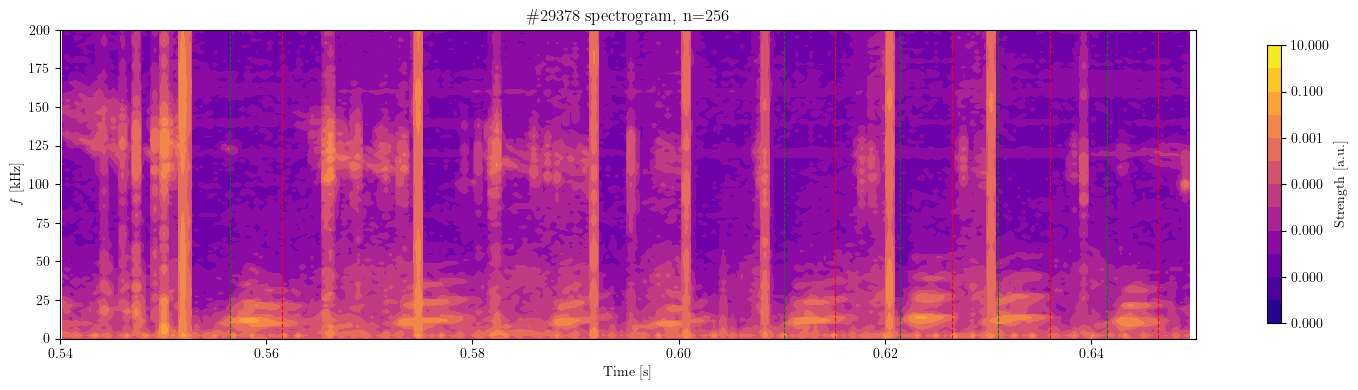

In [13]:
centres = [0.559, 0.6127, 0.624, 0.6335, 0.644] #[0.559, 0.575, 0.59, 0.6127, 0.624, 0.6335, 0.644]
manuals = [[i-0.0025, i+0.0025] for i in centres]
_ = sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[2], n=8, vlines=manuals, plot=True)

For each window containing the harmonics produce a dispersion relation. Uses angular positions of coils relative to centre of magnetic axis.

In [ ]:
if True:
    for i in range(len(manuals)):
        centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
        coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
        xlabel = "Poloidal mode number" 
        plot_title = "Mirnov Region 3, window " + str(i+1)
        f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
        plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=0.0e3, fmax=50e3, smooth_pts=5, conditional=False, save=False)

Plot Mirnov data filtered into different bands, for each region. Also plots $D_\alpha$ data over the top to compare with crash times.

In [ ]:
if False:
    fig, ax = plt.subplots(3, 1, sharex=False, figsize=(15,3*len(regions)))
    for i in range(len(regions)):
        idx1 = (np.abs(mirnov_time - regions[i][0])).argmin()
        idx2 = (np.abs(mirnov_time - regions[i][1])).argmin()
        dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
        dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()
        labels = []
        for coil in range(3,4):
            ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[coil][idx1:idx2], 10e3, 60e3, f_samp_mirnov),10), linewidth=0.5)
            ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[coil][idx1:idx2], 100e3, 160e3,  f_samp_mirnov),10), linewidth=0.5)
            ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_lowpass_filter(mirnov_data[coil][idx1:idx2], 5e3, f_samp_mirnov),10), "y", linewidth=0.5)

        ax2 = ax[i].twinx()
        ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
        ax2.set_ylabel(r"$D_\alpha$")

        #ax[i].set_xlim(left=crash_times[i][0]-0.001,right=crash_times[i][-1]+0.001)
        ax[i].set_xlim(left=mirnov_time[idx1], right=mirnov_time[idx2])
        ax[i].set_ylim(bottom=-0.1,top=0.1)
        ax[i].legend([r"$10\leq f\leq60$ kHz", r"$100\leq f\leq160$ kHz", r"$f\leq5$ kHz"], bbox_to_anchor=(1.05, 0.5))
        ax[i].set_xlabel("Time [s]")
        ax[i].set_ylabel("Signal [V]")
        ax[i].set_title("\#" + str(shot) + " filtered Mirnov signals, region " + str(i+1) + ", coil 212")

    fig.subplots_adjust(hspace=0.75)
    #plt.savefig("mirnov_filt_combi.pdf", bbox_inches="tight", format="pdf")
    plt.show()

As above, but plot each band on separate axes so some things can be seen better.

In [ ]:
if False:
    for i in range(len(regions)):
        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,9))
        idx1 = (np.abs(mirnov_time - regions[i][0])).argmin()
        idx2 = (np.abs(mirnov_time - regions[i][1])).argmin()
        dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
        dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()

        ax[0].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[3][idx1:idx2], 10e3, 60e3, f_samp_mirnov),10), linewidth=0.5)
        ax[0].set_ylabel(r"$10\leq f\leq60$ kHz signal [V]")
        ax[0].set_ylim(bottom=-0.15, top=0.15)

        ax[1].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[3][idx1:idx2], 100e3, 160e3,  f_samp_mirnov),10), linewidth=0.5)
        ax[1].set_ylabel(r"$100\leq f\leq160$ kHz signal [V]")
        ax[1].set_ylim(bottom=-0.05, top=0.05)

        ax[2].plot(mirnov_time[idx1:idx2], smooth(butter_lowpass_filter(mirnov_data[3][idx1:idx2], 5e3, f_samp_mirnov),10), linewidth=0.5)
        ax[2].set_ylabel(r"$f\leq5$ kHz signal [V]")
        ax[2].set_ylim(bottom=-0.075, top=0.075)    

        for x in range(3):
            ax2 = ax[x].twinx()
            ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
            ax2.set_ylabel(r"$D_\alpha$")
        ax[-1].set_xlim(left=mirnov_time[idx1], right=mirnov_time[idx2])
        ax[-1].set_xlabel("Time [s]")
        ax[0].set_title("\#" + str(shot) + " filtered Mirnov signals, region " + str(i+1) + ", coil 212")
        fig.subplots_adjust(hspace=0)
        #plt.savefig("reg_" + str(i+1) + "_mirnov_filt_seperated.pdf", format="pdf", bbox_inches="tight")
        plt.show()

As above, but this time using BES data. $f\leq5$ kHz band is uninteresting and includes turbulence so don't look at it.

In [16]:
if False:
    for i in range(len(regions)):
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
        idx1 = (np.abs(bes_time - regions[i][0])).argmin()
        idx2 = (np.abs(bes_time - regions[i][1])).argmin()
        dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
        dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()

        ax[0].plot(bes_time[idx1:idx2], smooth(butter_bandpass_filter(fluct_data[5][idx1:idx2], 10e3, 60e3, f_samp),10), linewidth=0.5)
        ax[0].set_ylabel(r"$10\leq f\leq60$ kHz intensity")
        ax[0].set_ylim(bottom=-0.3, top=0.3)

        ax[1].plot(bes_time[idx1:idx2], smooth(butter_bandpass_filter(fluct_data[5][idx1:idx2], 100e3, 160e3,  f_samp),10), linewidth=0.5)
        ax[1].set_ylabel(r"$100\leq f\leq160$ kHz intensity")
        ax[1].set_ylim(bottom=-0.05, top=0.05)

        for x in range(2):
            ax2 = ax[x].twinx()
            ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
            ax2.set_ylabel(r"$D_\alpha$")
        ax[-1].set_xlim(left=bes_time[idx1], right=bes_time[idx2])
        ax[-1].set_xlabel("Time [s]")
        ax[0].set_title("\#" + str(shot) + " filtered BES signals, region " + str(i+1) + ", channel 6")
        fig.subplots_adjust(hspace=0)
        plt.savefig("reg_" + str(i+1) + "_BES_filt_seperated.pdf", format="pdf", bbox_inches="tight")
        #plt.show()

Make some phase relation plots for each window in region 3 containing the harmonics.

In [ ]:
for i in range(len(manuals)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    
    xlabel = "Poloidal mode number" 
    plot_title = "Mirnov Region 3, window " + str(i+1)
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=0.0e3, fmax=60.0e3, phases=True, save=False)

## Integrating magnetics with BES

Look at features that show up in the time FFT of a channel and compare scale of features seen in each coil and relation to their distance apart

Plot both BES focal points and Mirnov coil positions, with some demo paths between them

In [ ]:
if True:
    fig, ax = plt.subplots(1,1)
    ax.scatter(apdpos[:,0], apdpos[:,1], marker="s", s=10, color="red", label="BES channels")
    ax.scatter(coilpos[:,0], coilpos[:,1], marker="o", color="purple", label="Mirnov coils")
    for ch in range(7,32,8):
        for coil in range(6):
            dist, path = bes_mirnov_dist(apdpos, ch, coilpos, coil)
            #ax.plot([apdpos[ch,0], apdpos[ch,0]+path[0]], [apdpos[ch,1], apdpos[ch,1]+path[1]], "k--", linewidth=0.5)
    ax.contour(equilib_R,equilib_Z,equilib_psi[120],[1.0], colors=["blue"])
    
    for i, txt in enumerate(coil_nums):
        ax.annotate(txt, (coilpos[i,0]+0.02, coilpos[i,1]-0.01))
    
    for i in range(8):
        ax.annotate(i+1, (apdpos[i,0]-0.005, apdpos[i,1]-0.03), fontsize=8)
    
    ax.set_xlabel(r"$R$ [m]")
    ax.set_ylabel(r"$Z$ [m]")
    ax.set_title(shotlabel + r", $t =$ " + str(np.round(equilib_time[120],2)) + " s")
    ax.set_xlim(left=1,right=2)
    ax.set_ylim(bottom=-0.4,top=0.4)
    ax.legend(loc="lower left")
    plt.savefig("ch_coil_sep.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
fluct_filt = butter_highpass_filter(fluct_data, 5e3, f_samp)
mirnov_filt = butter_highpass_filter(mirnov_data, 5e3, f_samp_mirnov)

In [ ]:
freqs, coeffs = fft_channel(bes_time, fluct_filt, 5, pre_crash_windows[2][0])
coeffs_sum = np.abs(coeffs)
for window in range(1,len(pre_crash_windows[2])):
    coeffs_sum += np.abs(fft_channel(bes_time, fluct_filt, 5, pre_crash_windows[2][i])[1])
fig, ax = plt.subplots()
ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)**2),10))
ax.set_xlim(left=10, right=30)
ax.set_xlabel("Frequency [kHz]")
ax.set_ylim(bottom=0)
ax.set_ylabel("Power")
ax.set_title("BES channel 6 FFT")

limits = [16,25.5]
ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)

#plt.show()

In [ ]:
areas = []
for ch in range(32):
    freqs, coeffs = fft_channel(bes_time, fluct_filt, ch, pre_crash_windows[2][0])
    coeffs_sum = np.abs(coeffs)
    for window in range(1,len(pre_crash_windows[2])):
        coeffs_sum += np.abs(fft_channel(bes_time, fluct_filt, ch, pre_crash_windows[2][i])[1])
    
    if False:
        fig, ax = plt.subplots()
        ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)**2),10))
        ax.set_xlim(left=10, right=30)
        ax.set_xlabel("Frequency [kHz]")
        ax.set_ylim(bottom=0)
        ax.set_ylabel("Power")

        limits = [16,25.5]
        ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        plt.show()
        plt.close()
    
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    areas.append(full-noise)

Function to determine frequency peaks from Mirnov dispersion relations.

Sum abs across wavenumbers, produce smoother frequency profile.

In [ ]:
def get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi,
                    mirnov_time, mirnov_data, f_start, f_end, timeslice):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, timeslice)
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))

    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, timeslice)
    f_start_idx = (np.abs(f_arr - f_start)).argmin()
    f_end_idx = (np.abs(f_arr - f_end)).argmin()
    
    sum_over_k = np.sum(np.abs(kf_matrix)**2,axis=1)
    smoothed = np.log(smooth(sum_over_k,10))[f_start_idx:f_end_idx]
    f_arr = f_arr[f_start_idx:f_end_idx]
    
    fig, ax = plt.subplots(1,1)
    ax.plot(f_arr*1e-3, smoothed, linewidth=0.5)
    ax.set_xlim(left=f_start*1e-3, right=f_end*1e-3)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylabel("Power [a.u.]")
    plt.show()
    plt.close()
    return sum_over_k

In [ ]:
if False:
    for window in manuals:
        get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi, mirnov_time, mirnov_data, 5e3, 15e3, window)

For each window in manuals, where do we see frequency peaking?

In [14]:
harmonic_freqs = np.asarray([
    [[8.0,14.0], [18.0, 26.0], [29.0, 38.0]],
    [[8.0,14.0], [20.0, 27.0], [31.0, 40.0]],
    [[10.0,16.0], [22.0, 29.0], [36.0, 42.0]],
    [[8.0,15.0], [22.0, 30.0], [34.0, 43.0]],
    [[7.0,14.0], [19.0, 26.0], [29.0, 36.0]]
])*1e3

For each harmonic for each of manuals, re-compute dispersion relation, sum contributions in the range and plot poloidal mode number profile.

1 & 1 & 0.264 & 0.857 & 2.807 \\


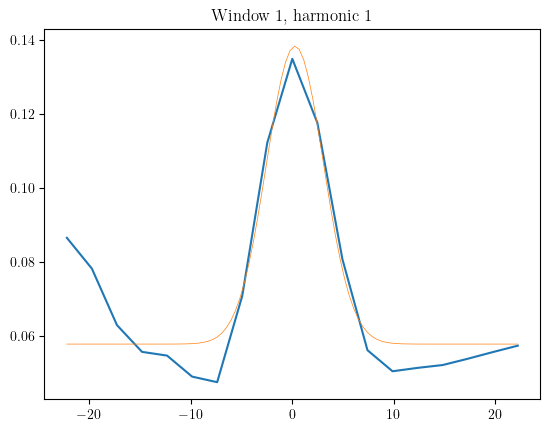

1 & 2 & -0.99 & 0.922 & 3.553 \\


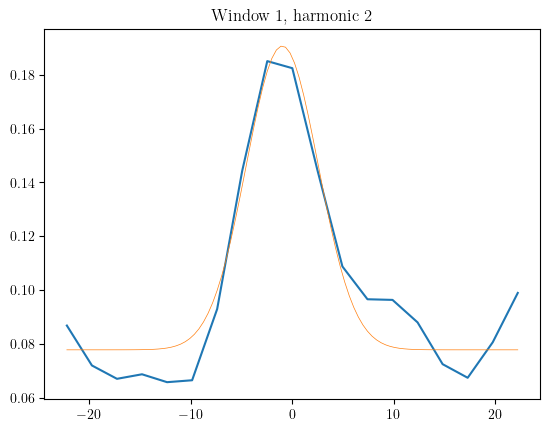

1 & 3 & 0.232 & 0.96 & 3.104 \\


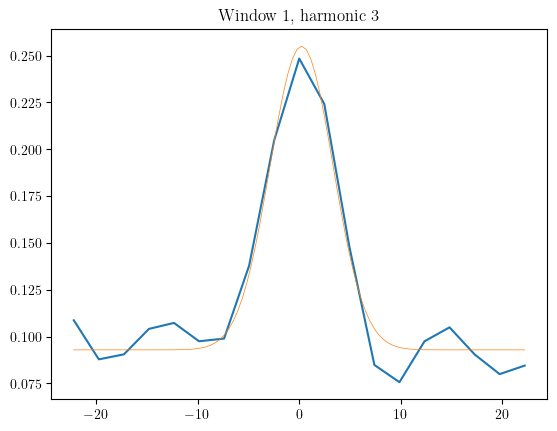

2 & 1 & 1.054 & 0.943 & 3.806 \\


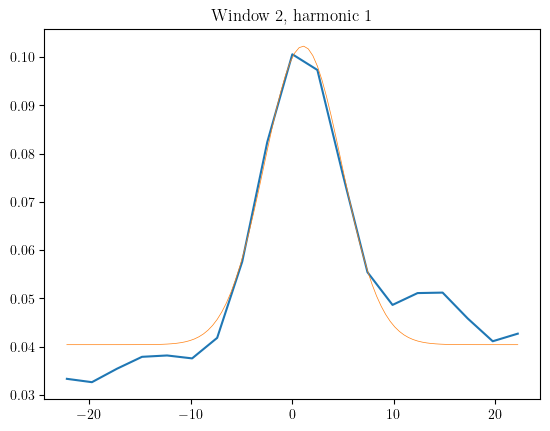

2 & 2 & -0.171 & 0.921 & 2.744 \\


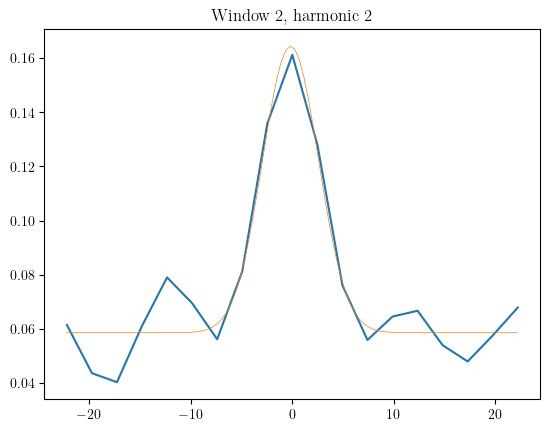

2 & 3 & -0.241 & 0.861 & 2.897 \\


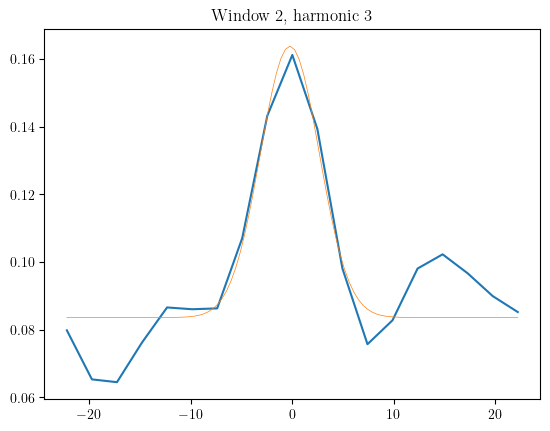

3 & 1 & 0.838 & 0.942 & 3.421 \\


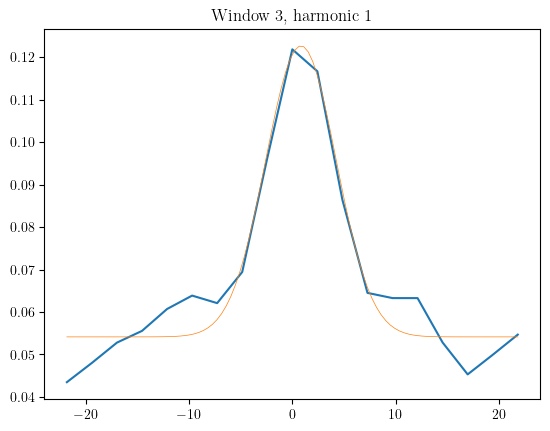

3 & 2 & 0.923 & 0.845 & 4.643 \\


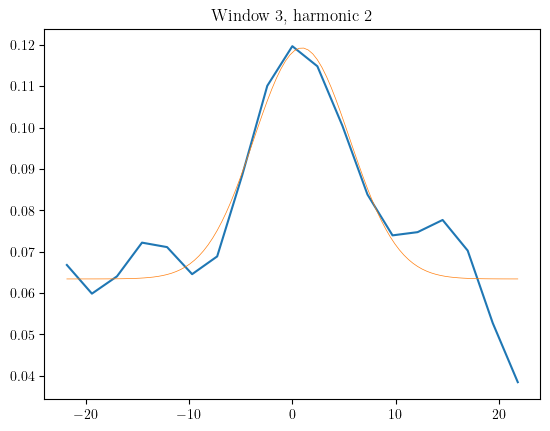

3 & 3 & -1.442 & 0.866 & 4.195 \\


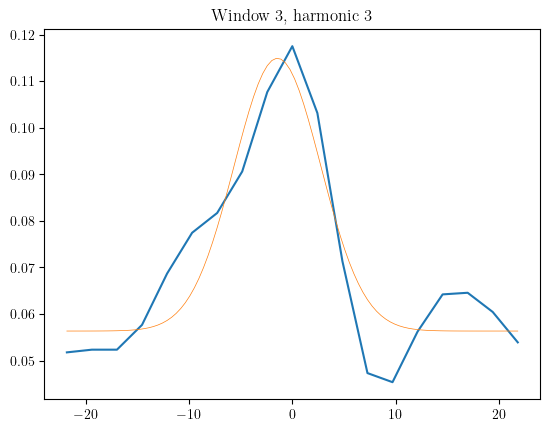

4 & 1 & 0.517 & 0.987 & 4.481 \\


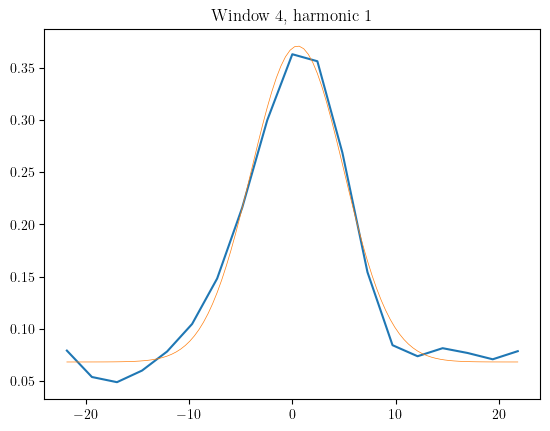

4 & 2 & -0.362 & 0.992 & 4.767 \\


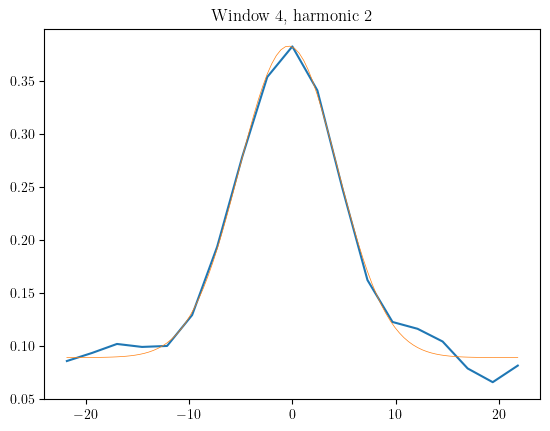

4 & 3 & -0.154 & 0.994 & 5.025 \\


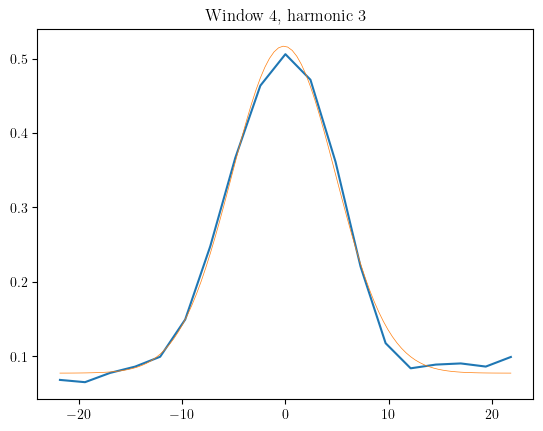

5 & 1 & -1.501 & 0.655 & 2.706 \\


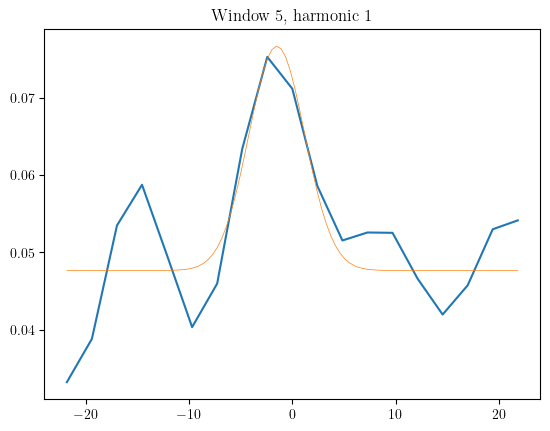

5 & 2 & 0.64 & 0.881 & 2.993 \\


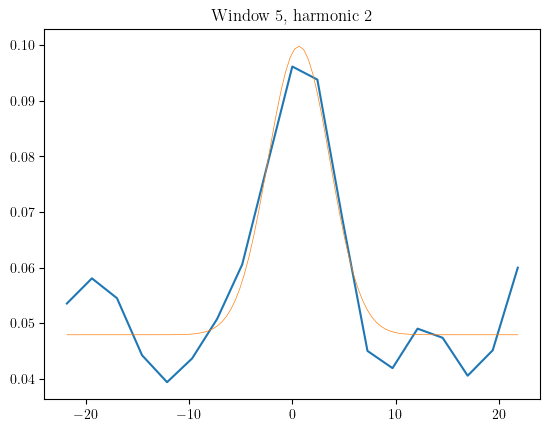

5 & 3 & 0.067 & 0.88 & 2.474 \\


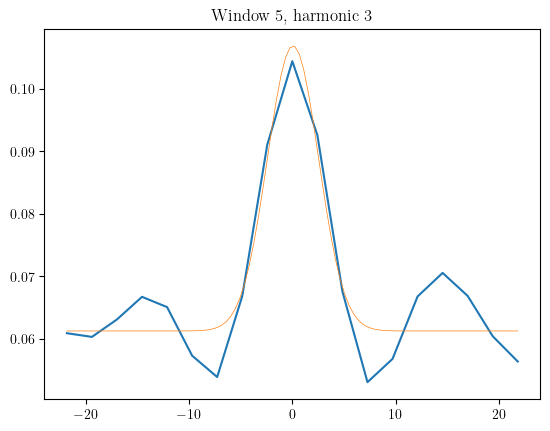

In [15]:
for i in range(len(manuals)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
    
    f_arr = f_arr[(np.abs(f_arr - 0.0)).argmin():]
    fit_go = 11 # default: 15
    fit_stop = 30 # default: 26
    
    for h in range(3):
        f_start = (np.abs(f_arr - harmonic_freqs[i,h,0])).argmin()
        f_stop = (np.abs(f_arr - harmonic_freqs[i,h,1])).argmin()
        profile = np.sum(np.abs(kf_matrix[f_start:f_stop+1,:])**2,axis=0)
        plt.plot(k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        plt.title("Window " + str(i+1) + ", harmonic " + str(h+1))
        
        popt, pcov = curve_fit(gaussian, k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        residuals = profile[fit_go:fit_stop] - gaussian(k_arr[fit_go:fit_stop], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[fit_go:fit_stop] - np.mean(profile[fit_go:fit_stop]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[fit_go], k_arr[fit_stop-1], 100)
        fit_y = gaussian(fit_x, *popt)
        print(i+1, "&", h+1, "&", str(np.round(popt[1],3)), "&", str(np.round(r_squared,3)), "&", str(np.round(popt[2],3)) , 2*chr(92))
        #print(popt)
        plt.plot(fit_x, fit_y, linewidth=0.5)
        
        plt.show()
        plt.close()

## Region 2 focus

    1) Choose windows of time just before the crashes that contain interesting features.<br />
    2) Plot dispersion relations to look at harmonics in more detail.<br />
    3) Select frequency ranges to sum to generate mode number profile.<br />
    4) Generate the mode number profiles, apply a Gaussian fit to find the central peak.

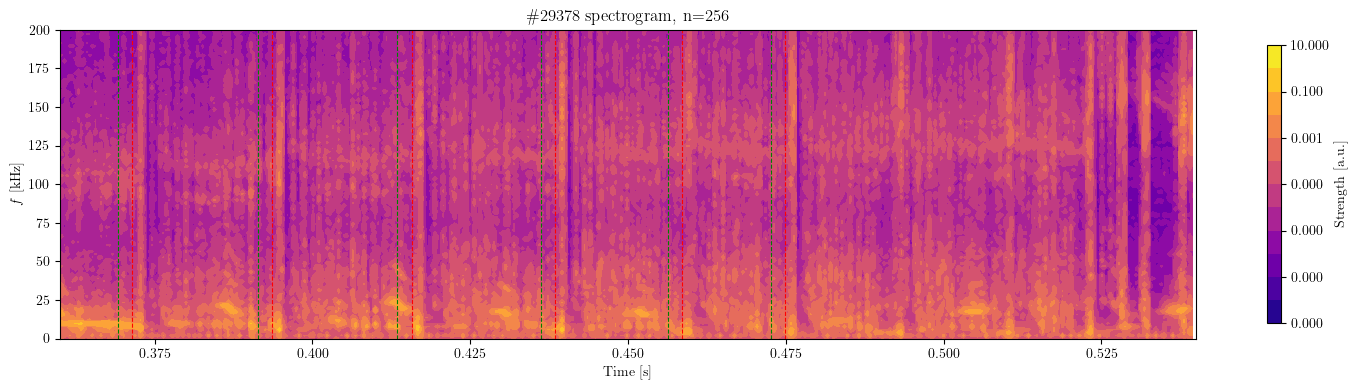

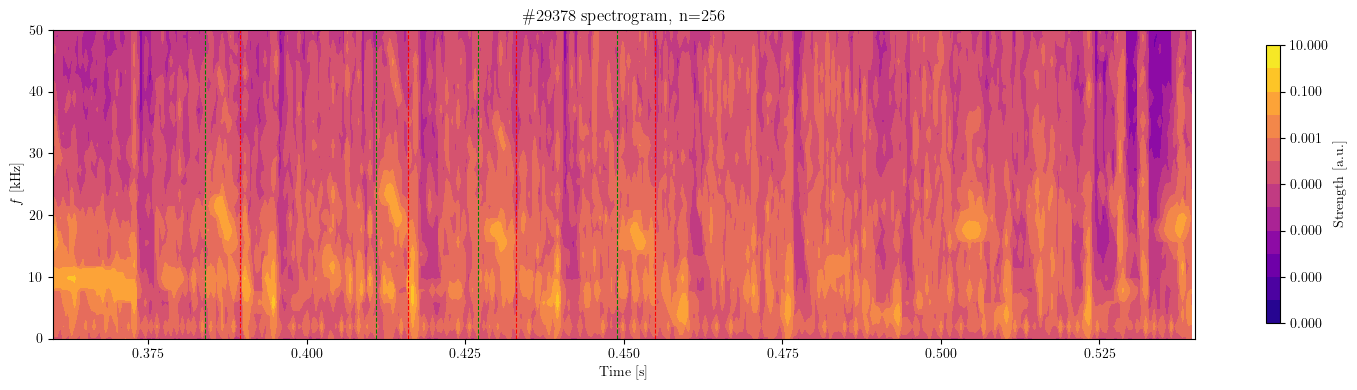

In [102]:
sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[1], n=8, vlines=pre_crash_windows[1], plot=True)
pcw2 = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=12e-3, end_shift=1e-3)
manuals2 = [[0.384,0.3895], [0.411, 0.416], [0.427, 0.433], [0.449, 0.455]]
_=sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[1], n=8, vlines=manuals2, freq_lims=[0.0,50.0], plot=True)

In [ ]:
for i in range(len(manuals2)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals2[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    
    plot_title = "Mirnov region 2, window " + str(i+1)
    xlabel = "Poloidal mode number"
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals2[i])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, plot_title, xlabel, fmin=0.0e3, fmax=50.0e3, smooth_pts=5, save=False)

In [ ]:
#for window in manuals2:
#    get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi, mirnov_time, mirnov_data, 5e3, 15e3, window)

In [ ]:
reg2_harmonics = np.asarray([
    [[6.0, 14.0], [14.0, 24.0], [31.0, 42.0]],
    [[5.0, 12.0], [17.0, 26.0], [37.0, 50.0]],
    [[6.0, 13.5], [14.0, 16.0], [29.0, 35.0]],
    [[7.5, 11.0], [15.0, 17.0], [29.0, 35.0]],
])*1.0e3

In [ ]:
reg2_mode_numbers = []
for i in range(3,len(reg2_harmonics)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals2[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals2[i])
    
    f_arr = f_arr[(np.abs(f_arr - 0.0)).argmin():]
    fit_go = 11 # default: 11
    fit_stop = 29# default: 29
    this_window = []
    
    for h in range(3):
        f_start = (np.abs(f_arr - reg2_harmonics[i,h,0])).argmin()
        f_stop = (np.abs(f_arr - reg2_harmonics[i,h,1])).argmin()
        profile = np.sum(np.abs(kf_matrix[f_start:f_stop+1,:])**2,axis=0)
        plt.plot(k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        plt.title("Region 2, window " + str(i+1) + ", harmonic " + str(h+1))
        
        popt, pcov = curve_fit(gaussian, k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        residuals = profile[fit_go:fit_stop] - gaussian(k_arr[fit_go:fit_stop], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[fit_go:fit_stop] - np.mean(profile[fit_go:fit_stop]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[fit_go], k_arr[fit_stop-1], 100)
        fit_y = gaussian(fit_x, *popt)
        this_window.append(popt[1])
        print(i+1, "&", h+1, "&", str(np.round(popt[1],3)), "&", str(np.round(r_squared,3)), "&", str(np.round(popt[2],3)) , 2*chr(92))
        plt.plot(fit_x, fit_y, linewidth=0.5)
        
        plt.show()
        plt.close()
    reg2_mode_numbers.append(this_window)

In [ ]:
mareas = []
window = 1
harmonic = 1
for coil in range(6):
    freqs, coeffs = fft_channel(mirnov_time, mirnov_data, coil, manuals2[window])
    coeffs_sum = np.abs(coeffs)**2
    limits = reg2_harmonics[window,harmonic]*1e-3
    
    fig, ax = plt.subplots()
    ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)),10))
    ax.set_xlim(left=10, right=30)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Power")
    ax.set_title("Mirnov coil " + str(coil_nums[coil]) + " FFT")

    ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    plt.show()
    plt.close()
        
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    mareas.append(full-noise)

In [ ]:
areas = []
for ch in range(8):
    freqs, coeffs = fft_channel(bes_time, fluct_data, ch, manuals2[0])
    coeffs_sum = np.abs(coeffs)**2

    fig, ax = plt.subplots()
    ax.plot(freqs*1e-3, smooth(coeffs_sum,10))
    ax.set_xlim(left=10, right=30)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Power")
    ax.set_title("BES channel " + str(ch) + " FFT")

    limits = reg2_harmonics[1,1]*1e-3
    ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    #plt.show()
    
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    areas.append(full-noise)

In [ ]:
plt.plot(np.arange(0,8), areas)

In [ ]:
freq_ranges = np.asarray([
    [[7.0, 12.0], [15.0, 23.0], [31.0, 42.0]],
    [[6.0, 10.0], [17.0, 26.0], [37.0, 50.0]],
    [[6.0, 13.5], [14.0, 19.0], [29.0, 35.0]],
    [[7.0, 10.5], [14.0, 19.0], [29.0, 35.0]],
])*1.0e3

for i in range(1):#len(manuals2)):
    for col in range(8):
        print("\n")
        centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
        coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
        f_arr_mirnov, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_filt, coilpos_angles, manuals[i])
        f_profile_mirnov = np.sum(np.abs(kf_matrix)**2, axis=1)

        f_arr_BES, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_filt, apdpos, col, manuals[i])
        f_profile_BES = np.sum(np.abs(kf_matrix)**2, axis=1)

        fig, ax = plt.subplots(2,1, sharex=True)
        ax[0].plot(f_arr_mirnov*1e-3, smooth(f_profile_mirnov,10)*1e-3)
        ax[1].plot(f_arr_BES*1e-3, smooth(f_profile_BES,10)*1e-3)

        """ax[0].vlines(freq_ranges[i][0]*1e-3, ax[0].get_ylim()[0], ax[0].get_ylim()[1], "k", linewidth=0.5)
        ax[1].vlines(freq_ranges[i][0]*1e-3, ax[1].get_ylim()[0], ax[1].get_ylim()[1], "k", linewidth=0.5)
        ax[0].vlines(freq_ranges[i][1]*1e-3, ax[0].get_ylim()[0], ax[0].get_ylim()[1], "k", linewidth=0.5)
        ax[1].vlines(freq_ranges[i][1]*1e-3, ax[1].get_ylim()[0], ax[1].get_ylim()[1], "k", linewidth=0.5)"""

        ax[0].set_ylabel("Mirnov Power [a.u.]")
        ax[1].set_ylabel("BES Power [a.u.]")
        ax[1].set_xlabel("Frequency [kHz]")

        plt.xlim(left=5, right=30)
        fig.subplots_adjust(hspace=0)
        plt.show()
        plt.close()

        # Area calculation
        idx1_M, idx1_B = (np.abs(f_arr_mirnov-freq_ranges[i,0,0])).argmin(), (np.abs(f_arr_BES-freq_ranges[i,0,0])).argmin()
        idx2_M, idx2_B = (np.abs(f_arr_mirnov-freq_ranges[i,0,1])).argmin(), (np.abs(f_arr_BES-freq_ranges[i,0,1])).argmin()

        full1_M = trapz(smooth(f_profile_mirnov,10)[idx1_M:idx2_M+1], f_arr_mirnov[idx1_M:idx2_M+1])
        noise1_M = trapz([smooth(f_profile_mirnov,10)[idx1_M], smooth(f_profile_mirnov,10)[idx2_M]], [f_arr_mirnov[idx1_M], f_arr_mirnov[idx2_M]])
        print("Peak 1 Mirnov area:", full1_M-noise1_M)

        full1_B = trapz(smooth(f_profile_BES,10)[idx1_B:idx2_B+1], f_arr_BES[idx1_B:idx2_B+1])
        noise1_B = trapz([smooth(f_profile_BES,10)[idx1_B], smooth(f_profile_BES,10)[idx2_B]], [f_arr_BES[idx1_B], f_arr_BES[idx2_B]])
        print("Peak 1 BES area:", full1_B-noise1_B)

        print("Mirnov:BES area ratio:", (full1_M-noise1_M)/(full1_B-noise1_B))

In [ ]:
for col in range(8):
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_filt, apdpos, col, manuals2[0])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "Col " + str(col+1), "Wavenumber", fmin=5.0e3, fmax=30.0e3, smooth_pts=4, conditional=False)

# 125 kHz region 3

In [ ]:
dists_in_sol

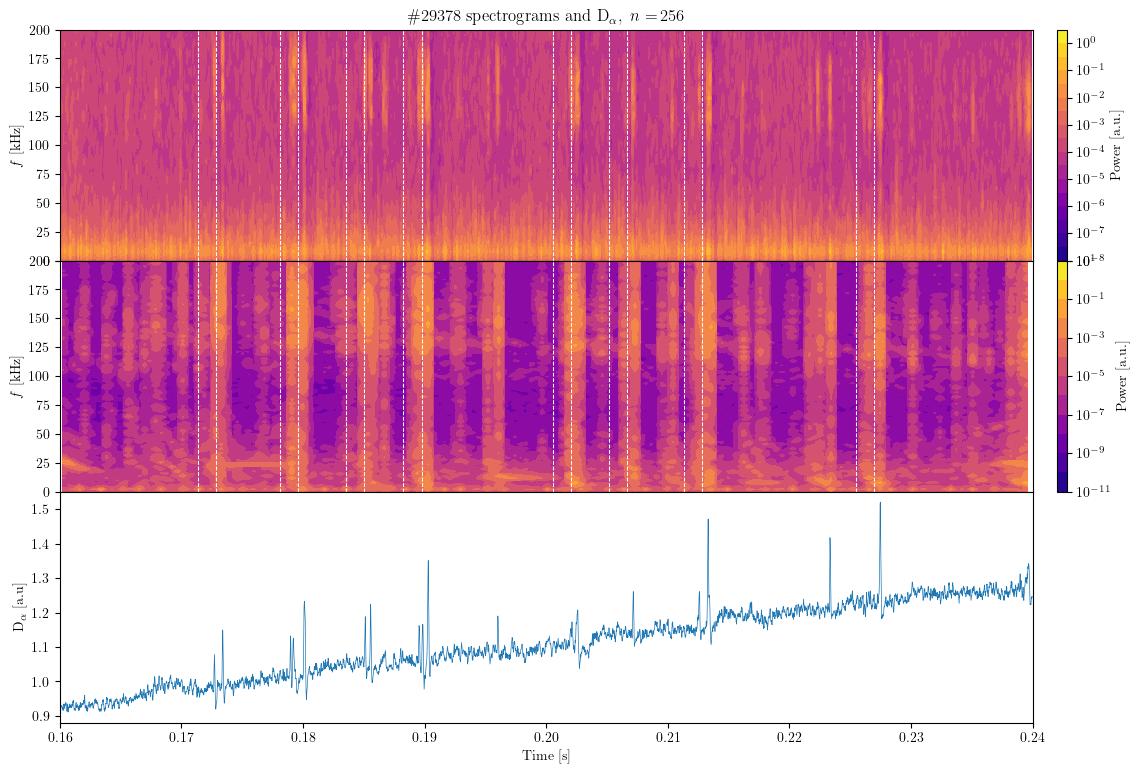

In [107]:
region = 0
fig, ax = plt.subplots(3,2, sharex=False, figsize=(13,9),
                       gridspec_kw={'height_ratios':[1,1,1], 'width_ratios':[95,1], 'wspace':0.05})

freq1, times1, Sxx1 = sum_full_spectrogram(shot, bes_time, fluct_data, 6, regions[region], n=8)
freq2, times2, Sxx2 = sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[region], n=8, plot=False)

cb1 = ax[0,0].contourf(times1,1e-3*freq1,Sxx1, 16, cmap=plt.get_cmap('plasma'), levels=[10**(i/10) for i in range(-80,10,5)],
                norm=(colors.LogNorm()))
ax[0,0].set_ylabel(r"$f$ [kHz]")
fig.colorbar(cb1, shrink=0.9, label="Power [a.u.]", format=ticker.FuncFormatter(fmt), cax=ax[0,1])

cb2 = ax[1,0].contourf(times2,1e-3*freq2,Sxx2, 16, cmap=plt.get_cmap('plasma'), levels=[10**i for i in range(-11,2)],
                norm=(colors.LogNorm()))
fig.colorbar(cb2, shrink=0.9, label="Power [a.u.]", format=ticker.FuncFormatter(fmt), cax=ax[1,1])
ax[1,0].set_ylabel(r"$f$ [kHz]")

for i in pre_crash_windows[0]:
    ax[0,0].vlines(i[0], 0, 200, 'w', linestyles="dashed", linewidth=0.75)
    ax[0,0].vlines(i[1], 0, 200, 'w', linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[0], 0, 200, 'w', linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[1], 0, 200, 'w', linestyles="dashed", linewidth=0.75)

for i in manuals:
    ax[0,0].vlines(i[0], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[0,0].vlines(i[1], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[0], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[1], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    
for i in manuals2:
    ax[0,0].vlines(i[0], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[0,0].vlines(i[1], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[0], 0, 200, "w", linestyles="dashed", linewidth=0.75)
    ax[1,0].vlines(i[1], 0, 200, "w", linestyles="dashed", linewidth=0.75)

for i in manuals3:
    ax[0,0].vlines(i[0], 0, 200, "c", linestyles="solid", linewidth=0.75)
    ax[0,0].vlines(i[1], 0, 200, "c", linestyles="solid", linewidth=0.75)
    ax[1,0].vlines(i[0], 0, 200, "c", linestyles="solid", linewidth=0.75)
    ax[1,0].vlines(i[1], 0, 200, "c", linestyles="solid", linewidth=0.75)
    
for i in elm_pcw:
    ax[0,0].vlines(i[0], 0, 200, '#00ff00', linestyles="dotted", linewidth=0.75)
    ax[0,0].vlines(i[1], 0, 200, '#00ff00', linestyles="dotted", linewidth=0.75)
    ax[1,0].vlines(i[0], 0, 200, '#00ff00', linestyles="dotted", linewidth=0.75)
    ax[1,0].vlines(i[1], 0, 200, '#00ff00', linestyles="dotted", linewidth=0.75)

ax[0,0].set_ylim([0,200])
ax[1,0].set_ylim([0,200])

idx1 = (np.abs(dalpha_time - regions[region][0])).argmin()
idx2 = (np.abs(dalpha_time - regions[region][1])).argmin()
ax[2,0].plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1]*1e-19, linewidth=0.5)
ax[2,0].set_ylabel(r"D$_\alpha$ [a.u]")
ax[2,0].set_xlabel("Time [s]")

ax[0,0].set_xlim(left=regions[region][0], right=regions[region][1])
ax[1,0].set_xlim(left=regions[region][0], right=regions[region][1])
ax[2,0].set_xlim(left=regions[region][0], right=regions[region][1])

ax[0,0].set_title("\#" + str(shot) + r" spectrograms and D$_\alpha,\ n=\,$" + 
            str(int(2**8)))

ax[0,0].set_xticks([])
ax[1,0].set_xticks([])
ax[2,1].axis("off")
fig.subplots_adjust(hspace=0)
plt.savefig("reg1_spectrograms.pdf", bbox_inches="tight")
plt.show()

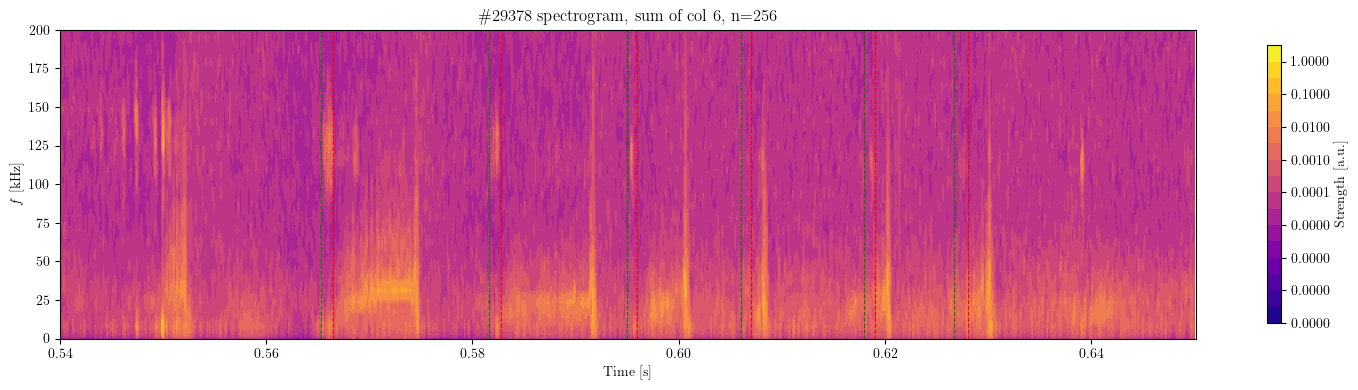

In [14]:
manuals3 = [[0.5653,0.5665], [0.5816,0.5828], [0.595,0.596], [0.606,0.607], [0.618,0.619], [0.6267,0.628]]

elm_pcw = []
for i in range(len(manuals3)):
    elm_pcw.append(np.array([manuals3[i][1], crash_times[2][1:][i]-0.0005]))
    
_ = sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 5, regions[2], vlines=manuals3, plot=True)

In [ ]:
def get_f_profile(f_arr, k_arr, kf_matrix, k_range, fmin=0.0, fmax=None, plot=False):
    if fmax == None:
        fmax = np.max(f_arr)
    f_start = (np.abs(f_arr-fmin)).argmin()
    f_end = (np.abs(f_arr-fmax)).argmin()
    k_start = (np.abs(k_arr-k_range[0])).argmin()
    k_end = (np.abs(k_arr-k_range[-1])).argmin() + 1
    
    f_profile = np.sum(np.abs(kf_matrix[:,k_start:k_end])**2, axis=1)
    
    if plot != False:
        fig, ax = plt.subplots(1,1)
        ax.plot(f_arr[f_start:f_end]*1e-3, smooth(f_profile[f_start:f_end],5), linewidth=0.5)
        ax.set_xlim(left=f_arr[f_start]*1e-3, right=f_arr[f_end]*1e-3)
        ax.set_title(plot)
        ax.set_xlabel("Frequency [kHz]")
        ax.set_ylabel("Power [a.u.]")
    return f_arr, f_profile

In [ ]:
def get_k_profile(f_arr, k_arr, kf_matrix, f_range, fit_range=None, fit=None, plot=False):
    f_start = (np.abs(f_arr-f_range[0])).argmin()
    f_end = (np.abs(f_arr-f_range[1])).argmin()    
    profile = np.sum(np.abs(kf_matrix[f_start:f_end,:])**2, axis=0)

    if fit != None:
        fit_start = 3#(np.abs(k_arr-fit_range[0])).argmin()
        fit_stop = 10#(np.abs(k_arr-fit_range[1])).argmin()+1
        popt, pcov = curve_fit(fit, k_arr[fit_start:fit_stop], profile[fit_start:fit_stop])
        residuals = profile[fit_start:fit_stop] - fit(k_arr[fit_start:fit_stop], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[fit_start:fit_stop] - np.mean(profile[fit_start:fit_stop]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[fit_start], k_arr[fit_stop-1], 100)
        fit_y = fit(fit_x, *popt)
    
    if plot != False:
        fig, ax = plt.subplots(1,1)
        ax.plot(k_arr, profile, "x")
        if fit != None:
            ax.plot(fit_x, fit_y, linewidth=0.5)
            annot = r"$\mu=$" + str(np.round(popt[1],3)) + ", $R^2=$" + str(np.round(r_squared,3))
            ax.legend(["Data", fit.__name__ + " fit"], loc="upper right")
            ax.text(0.01, 0.975, annot, ha='left', va='top', transform=ax.transAxes)
        ax.set_xlim(left=k_arr[0], right=k_arr[-1])
        ax.set_title(plot)
        ax.set_xlabel("Poloidal Mode number")
        ax.set_ylabel("Power [a.u.]")
    return k_arr, profile

In [ ]:
for window in range(len(manuals3)):
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, 5, manuals3[window])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "window " + str(window+1), "Wavenumber", fmin=0e3, fmax=250e3, smooth_pts=5)
    get_f_profile(f_arr, k_arr, kf_matrix, [-50,50], fmin=100e3, fmax=150e3, plot="title")
    get_k_profile(f_arr, k_arr, kf_matrix, [100e3,140e3], fit_range=[-20,18], fit=gaussian, plot="plot")
    
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals3[window])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals3[window])
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "window " + str(window+1), "Mode number", fmin=0e3, fmax=250e3, smooth_pts=5)
    get_f_profile(f_arr, k_arr, kf_matrix, [-20,20], fmin=75e3, fmax=150e3, plot="title")
    #get_k_profile(f_arr, k_arr, kf_matrix, [100e3,140e3], fit_range=[-20,18], fit=gaussian, plot="plot")

In [ ]:
def calc_mirnov_area(mirnov_time, mirnov_data, coil, fbounds, timeslice, plot=True):
    mirnov_norm = mirnov_data
    for i in range(len(mirnov_data)):
        mirnov_norm[i] = mirnov_data[i]/np.max(mirnov_data[i])
    
    tstart = (np.abs(mirnov_time-timeslice[0])).argmin()
    tend = (np.abs(mirnov_time-timeslice[1])).argmin()
    freqs, coeffs = fft_channel(mirnov_time, mirnov_norm, coil, timeslice)
    coeffs = smooth(np.abs(coeffs)**2,5)
    
    fstart = (np.abs(freqs-fbounds[0])).argmin()
    fend = (np.abs(freqs-fbounds[1])).argmin()
    
    full = trapz(coeffs[fstart:fend+1], freqs[fstart:fend+1])
    noise = trapz([coeffs[fstart], coeffs[fend]], [freqs[fstart], freqs[fend]])
    area = full-noise
    
    if plot != False:
        fig, ax = plt.subplots(1,1)
        ax.plot(freqs*1e-3, np.log(coeffs))
        ax.set_xlim(left=0, right=60)
        ax.vlines(freqs[fstart]*1e-3, ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        ax.vlines(freqs[fend]*1e-3, ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        ax.set_xlabel("Frequency [kHz]")
        ax.set_ylabel("Power [a.u.]")
        plt.show()
    
    return area

In [ ]:
mareas = []
rs = []
for coil in range(8):
    mareas.append(calc_mirnov_area(bes_time, fluct_data, coil, harmonic_freqs[0,0], manuals[0], plot=True))
    #centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[0])
    #rs.append(np.sqrt(coilpos[coil,0]-centre_R)**2 + (coilpos[coil,1]-centre_Z)**2)

In [ ]:
plt.plot(np.arange(0,8), mareas, "x")

In [ ]:
for i in mirnov_data:
    print(np.max(i))
    
for i in range(len(mirnov_data)):
    mirnov_data[i] = mirnov_data[i]/np.max(mirnov_data[i])
    
for i in mirnov_data:
    print(np.max(i))

## Filtered Data

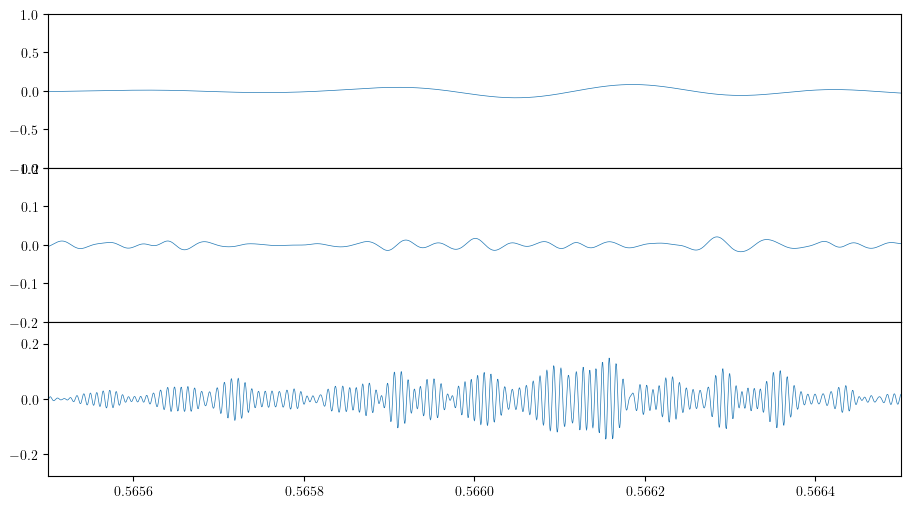

In [53]:
r = 2
c = 2
ch = 6

idx1m = (np.abs(mirnov_time-regions[r][0])).argmin()
idx2m = (np.abs(mirnov_time-regions[r][1])).argmin()
idx1b = (np.abs(bes_time-regions[r][0])).argmin()
idx2b = (np.abs(bes_time-regions[r][1])).argmin()

f5m = butter_lowpass_filter(mirnov_data[c], 5e3, f_samp_mirnov)
f20m = butter_bandpass_filter(mirnov_data[c], 10e3, 60e3, f_samp_mirnov)
f150m = butter_bandpass_filter(mirnov_data[c], 75e3, 200e3, f_samp_mirnov)

f5b = butter_lowpass_filter(fluct_data[ch], 5e3, f_samp_BES)
f20b = butter_bandpass_filter(fluct_data[ch], 15e3, 30e3, f_samp_BES)
f150b = butter_bandpass_filter(fluct_data[ch], 100e3, 150e3, f_samp_BES)

fig, ax = plt.subplots(3,1, figsize=(11,6), sharex=True)
ax[0].plot(mirnov_time[idx1m:idx2m], f5m[idx1m:idx2m], linewidth=0.5)
ax[1].plot(bes_time[idx1b:idx2b], f20b[idx1b:idx2b], linewidth=0.5)
ax[2].plot(bes_time[idx1b:idx2b], f150b[idx1b:idx2b], linewidth=0.5)


ax[0].set_ylim([-1,1])
ax[1].set_ylim([-0.2,0.2])

#ax[-1].set_xlim([mirnov_time[idx1m], mirnov_time[idx2m]])
ax[-1].set_xlim([0.5655, 0.5665])
fig.subplots_adjust(hspace=0)

In [28]:
lag, cc = cross_corr(f150b, f20b, 1/f_samp_BES)

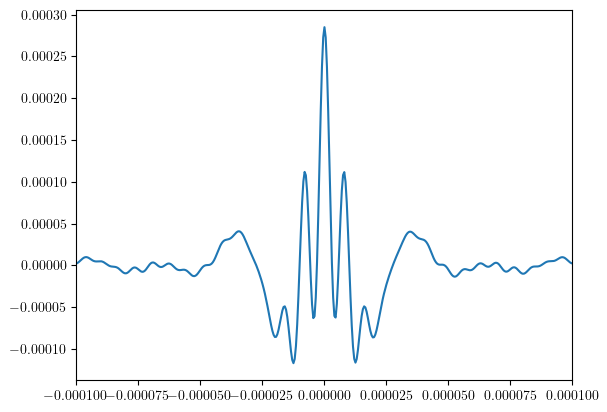

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(lag,cc)

ax.set_xlim([-0.0001,0.0001])
plt.show()

In [45]:
manuals[0][0]-0.005*0.5

0.5540000000000002

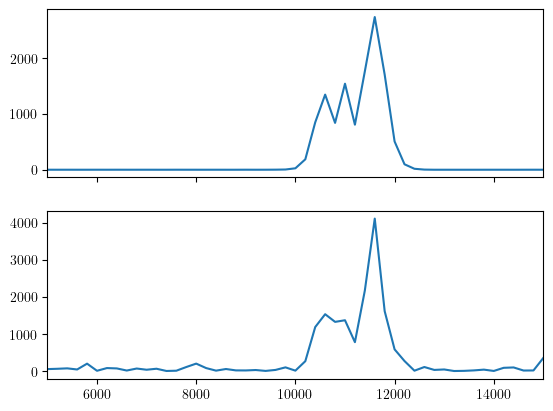

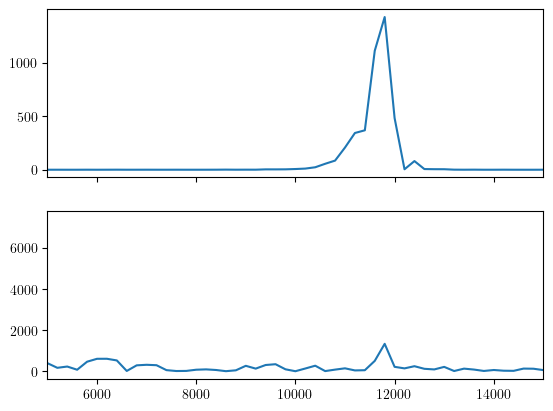

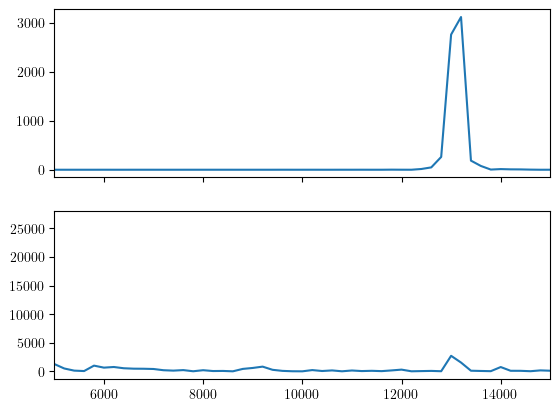

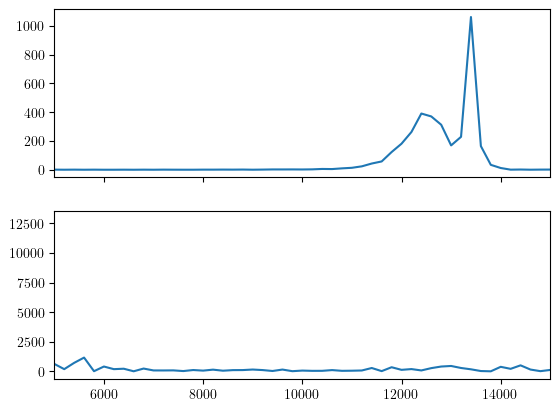

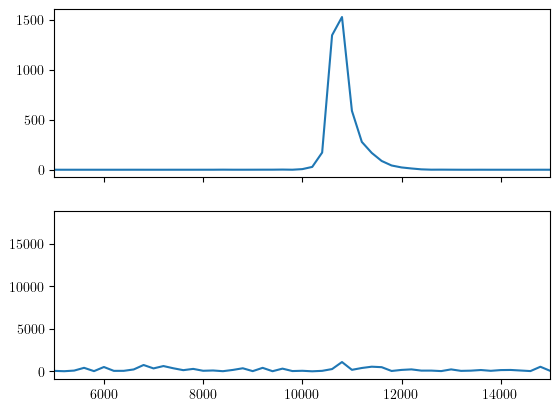

In [47]:
for i in range(5):
    f1, p1 = fft_channel(mirnov_time, mirnov_data, 2, manuals[i])
    f2, p2 = fft_channel(bes_time, fluct_data, 6, manuals[i])

    fig, ax = plt.subplots(2,1,sharex=True)
    ax[0].plot(f1,np.abs(p1)**2)
    ax[1].plot(f2,np.abs(p2)**2)

    ax[1].set_xlim([5000,15000])
    plt.show()